In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

# be clear what is "DERIVATIVE" of one simple function with one input?

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

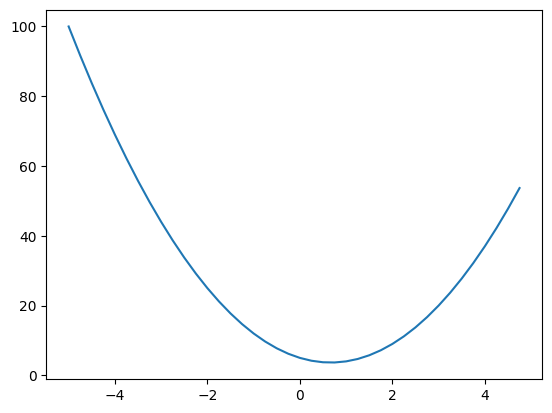

In [4]:
xs = np.arange(-5,5, 0.25) #from -5 t0 5 with step 0.5
ys = f(xs)
plt.plot(xs,ys)

In [5]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [6]:
#definition of derivative
h = 0.000001 #tent to zero by formula
x = 3 #try -3, 2/3
f(x)
(f(x + h) - f(x)) / h

14.000003002223593

In [7]:
#lets get more complex function
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [8]:
h = 0.0001

#inputs
a = 2
b = -3
c = 10

d1 = a*b + c #initial 
a += h #bumped a to a positive direction by a lil bit 
d2 = a*b + c #how its gonna effect 



print('d1', d1)
print('d2', d2)
print('actual slope', (d2-d1)/h)

d1 4
d2 3.999699999999999
actual slope -3.000000000010772


## Core "Value" object of Micrograd

In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): #children to kinda relate them to one another!
        self.data = data
        self._children = set(_children) #children for understanding the created value is from what, e.g. d is from addition of a,b
        self._op = _op #from what operation 
        self.label = label #to create a label for the dat values
        self.grad = 0.0 #initial set to zero, meaning slight change in the variables does not impact the loss function 
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other, _op='*'):
        out = Value(self.data * other.data, (self,other), '*')
        return out

In [10]:
obj1 = Value(3)
a = Value(2, label= 'a')
b = Value(-3, label='b')
c = Value(10, label='c')
#a + b #internally a.__add__(b)
e=a*b; e.label = 'e'
d=e + c; d.label = 'd'
f = Value(-2, label='f')
L = d * f; L.label='L' #overal output

In [11]:
d._children

{Value(data=-6), Value(data=10)}

In [12]:
d._op

'+'

## Graphical visualization 

In [73]:
#visualualize in graph
#trace is building the graph
def trace(root):
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build_graph(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format= 'svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        #for any value in graph, create a rectangular ('record') for it 
        dot.node(name=str(id(n)), label="{%s | data %.4f | grad%.4f}" % (n.label, n.data, n.grad), shape='record') #label = {%s | data %.4f | grad%.4f}" % (n.label, n.data)
        if n._op:
            #if this value is a result of an +/* operation, create an op node for it 
            dot.node(str(id(n)) + n._op, label = n._op)
            #connect it to the corresponding node 
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot    

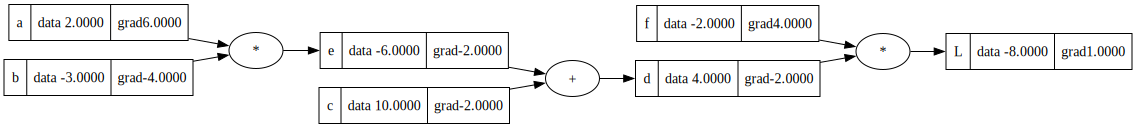

In [74]:
draw_dot(L)

we know how d impact L, and we know how c impact d(dd/dc) (plus sign d = e + c), now we wanna know how c impact L!
dd / dc=1
dd/ de = 1 (local derivative bc this have no clue of the whole network derivative L that we know!)
acheieved by Chain Rule
d = e + c 

WANT:
dL / dc = (dL/dd) * (dd/dc) second one is 1 bc of the plus sign so it sounds like it just passed it thro!

KNOW:
dL/dd
dd / dc
d = e + c



L = d * f
dl/dd = ? f

dL/dc


In [59]:
c.grad = -2
e.grad = -2


d.grad = -2
f.grad = 4

again for a , b

dL / de = -2
e = a * b

dL / da = (dL/de) * (de/da) = -2 * b = -2 * -3 = 6

In [72]:
a.grad = -2 * -3
b.grad = -2 * 2

## Manual backpro; simple expression

In [75]:
#what is the derivate of L with respect to L/ f to L
#in other word if we change f a lil bit, how does it affect the l 
def lol():
    h = 0.001
    a = Value(2, label= 'a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    #a + b #internally a.__add__(b)
    e=a*b; e.label = 'e'
    d=e + c; d.label = 'd'
    f = Value(-2, label='f')
    L = d * f; L.label='L' #overal output
    L1 = L.data

    a = Value(2, label= 'a') #2 +h change a w respect to a
    #a.data += h
    b = Value(-3, label='b')
    b.data += h
    c = Value(10, label='c')
    #a + b #internally a.__add__(b)
    e=a*b; e.label = 'e'
    #e.data += h
    d=e + c; d.label = 'd'
    f = Value(-2, label='f')
    L = d * f; L.label='L' #overal output
    L2  = L.data  #chsnge l W respect to L 

    print((L2 - L1)/h)

In [76]:
lol()

-3.9999999999995595


In [33]:
L.grad = 1.0